# 03_model_regression – Weekly Bookings Forecast

## Objectives
- Build and evaluate regression models to forecast **weekly bookings per region**.
- Compare a simple baseline (lag-based naive) to Linear Regression and tree-based models.
- Train an advanced boosted model with hyperparameter tuning.
- Select and save the final regression model pipeline for use in the Streamlit app.

## Inputs
- `data/processed/train_regression.csv`
- `data/processed/test_regression.csv`

## Outputs
- Regression performance metrics (MAE, MAPE, R²) for baseline and models.
- Evaluation plots (Actual vs Predicted, residuals).
- Tuned model parameters and rationale.
- Saved model pipeline:
  - `models/v1_bookings_model.pkl`


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
import joblib

sns.set(style="whitegrid")

BASE_DIR = Path("..").resolve()
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"

MODELS_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
train_reg = pd.read_csv(DATA_PROCESSED / "train_regression.csv", parse_dates=["week_start"])
test_reg = pd.read_csv(DATA_PROCESSED / "test_regression.csv", parse_dates=["week_start"])

train_reg.head(), test_reg.head()


(      region week_start  bookings_count  mean_temp_c  precip_mm  \
 0  highlands 2024-12-30             103    12.290070  24.999965   
 1  highlands 2025-01-06             108     0.039111  22.199585   
 2  highlands 2025-01-13              74     3.477432  30.135563   
 3  highlands 2025-01-20              95     7.164116  45.228408   
 4  highlands 2025-01-27              93     7.475139  41.118787   
 
    snowfall_flag  wind_speed_kph  visibility_km weather_severity_bin  year  \
 0              0       24.925994       7.387762                 mild  2024   
 1              0        2.373245       7.130601                 mild  2025   
 2              0       49.353812       8.026752               severe  2025   
 3              0       38.264073       8.558483             moderate  2025   
 4              0       34.961207       8.732666             moderate  2025   
 
    week_number  month  is_bank_holiday_week  is_peak_winter  lag_1w_bookings  \
 0            1     12           

In [3]:
# Target
target_col = "bookings_count"

# Features we want to use
categorical_features = ["region", "weather_severity_bin"]
numeric_features = [
    "mean_temp_c",
    "precip_mm",
    "snowfall_flag",
    "wind_speed_kph",
    "visibility_km",
    "year",
    "week_number",
    "month",
    "is_bank_holiday_week",
    "is_peak_winter",
    "lag_1w_bookings",
    "lag_4w_mean",
    "lag_52w_bookings",
]

feature_cols = categorical_features + numeric_features

X_train = train_reg[feature_cols].copy()
y_train = train_reg[target_col].copy()

X_test = test_reg[feature_cols].copy()
y_test = test_reg[target_col].copy()

X_train.head()


,region,weather_severity_bin,mean_temp_c,precip_mm,snowfall_flag,wind_speed_kph,visibility_km,year,week_number,month,is_bank_holiday_week,is_peak_winter,lag_1w_bookings,lag_4w_mean,lag_52w_bookings
0,highlands,mild,12.290070,24.999965,0,24.925994,7.387762,2024,1,12,1,1,93.0,82.00,85.0
1,highlands,mild,0.039111,22.199585,0,2.373245,7.130601,2025,2,1,0,1,103.0,89.75,68.0
2,highlands,severe,3.477432,30.135563,0,49.353812,8.026752,2025,3,1,0,1,108.0,97.50,103.0
3,highlands,moderate,7.164116,45.228408,0,38.264073,8.558483,2025,4,1,0,1,74.0,94.50,98.0
4,highlands,moderate,7.475139,41.118787,0,34.961207,8.732666,2025,5,1,0,1,95.0,95.00,76.0


In [4]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)


In [5]:
# Baseline prediction: use lag_1w_bookings as the forecast
# (for any rows where lag is missing, we'll fallback to the training mean)
baseline_pred = X_test["lag_1w_bookings"].copy()

fallback_value = y_train.mean()
baseline_pred = baseline_pred.fillna(fallback_value)

mae_baseline = mean_absolute_error(y_test, baseline_pred)
mape_baseline = np.mean(np.abs((y_test - baseline_pred) / np.maximum(y_test, 1))) * 100
r2_baseline = r2_score(y_test, baseline_pred)

mae_baseline, mape_baseline, r2_baseline


(14.71219512195122, np.float64(16.511314634392985), 0.5121951547889807)

In [6]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE": mape, "R2": r2}

baseline_metrics = regression_metrics(y_test, baseline_pred)
baseline_metrics


{'MAE': 14.71219512195122,
 'MAPE': np.float64(16.511314634392985),
 'R2': 0.5121951547889807}

In [7]:
linreg_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
    ]
)

linreg_pipe.fit(X_train, y_train)

y_pred_lin_train = linreg_pipe.predict(X_train)
y_pred_lin_test = linreg_pipe.predict(X_test)

lin_train_metrics = regression_metrics(y_train, y_pred_lin_train)
lin_test_metrics = regression_metrics(y_test, y_pred_lin_test)

lin_train_metrics, lin_test_metrics


({'MAE': 10.005580858752664,
  'MAPE': np.float64(10.842005869245511),
  'R2': 0.8251958787974321},
 {'MAE': 9.05628160443948,
  'MAPE': np.float64(10.251189302111005),
  'R2': 0.8134091942470753})

In [8]:
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", rf_reg)
    ]
)

rf_pipe.fit(X_train, y_train)

y_pred_rf_train = rf_pipe.predict(X_train)
y_pred_rf_test = rf_pipe.predict(X_test)

rf_train_metrics = regression_metrics(y_train, y_pred_rf_train)
rf_test_metrics = regression_metrics(y_test, y_pred_rf_test)

rf_train_metrics, rf_test_metrics


({'MAE': 4.288589285714286,
  'MAPE': np.float64(4.6944575067896315),
  'R2': 0.9660118176002712},
 {'MAE': 9.967707317073172,
  'MAPE': np.float64(11.280805259698576),
  'R2': 0.7688976228320596})

In [9]:
models_summary = pd.DataFrame.from_dict(
    {
        "baseline_lag1": baseline_metrics,
        "linear_regression": lin_test_metrics,
        "random_forest": rf_test_metrics,
    },
    orient="index"
)

models_summary


,MAE,MAPE,R2
baseline_lag1,14.712195,16.511315,0.512195
linear_regression,9.056282,10.251189,0.813409
random_forest,9.967707,11.280805,0.768898


In [10]:
xgb_reg = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"  # usually faster
)

xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", xgb_reg),
    ]
)


In [11]:
param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [3, 5, 7],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__subsample": [0.7, 0.9, 1.0],
    "regressor__colsample_bytree": [0.7, 0.9, 1.0],
    "regressor__min_child_weight": [1, 3, 5],
}


In [12]:
grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'regressor__colsample_bytree': [0.7, 0.9, ...], 'regressor__learning_rate': [0.05, 0.1, ...], 'regressor__max_depth': [3, 5, ...], 'regressor__min_child_weight': [1, 3, ...], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [13]:
best_xgb_pipe = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

best_params, best_score


({'regressor__colsample_bytree': 0.7,
  'regressor__learning_rate': 0.05,
  'regressor__max_depth': 3,
  'regressor__min_child_weight': 5,
  'regressor__n_estimators': 100,
  'regressor__subsample': 0.7},
 np.float64(13.09292475382487))

In [14]:
y_pred_xgb_train = best_xgb_pipe.predict(X_train)
y_pred_xgb_test = best_xgb_pipe.predict(X_test)

xgb_train_metrics = regression_metrics(y_train, y_pred_xgb_train)
xgb_test_metrics = regression_metrics(y_test, y_pred_xgb_test)

xgb_train_metrics, xgb_test_metrics


({'MAE': 9.305806159973145,
  'MAPE': np.float64(10.27659262954663),
  'R2': 0.8480446338653564},
 {'MAE': 9.373900413513184,
  'MAPE': np.float64(10.697943470333561),
  'R2': 0.7976915240287781})

In [15]:
models_summary = pd.DataFrame.from_dict(
    {
        "baseline_lag1": baseline_metrics,
        "linear_regression": lin_test_metrics,
        "random_forest": rf_test_metrics,
        "xgboost_tuned": xgb_test_metrics,
    },
    orient="index"
)

models_summary


,MAE,MAPE,R2
baseline_lag1,14.712195,16.511315,0.512195
linear_regression,9.056282,10.251189,0.813409
random_forest,9.967707,11.280805,0.768898
xgboost_tuned,9.373900,10.697943,0.797692


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/regression_actual_vs_predicted_xgb.png')

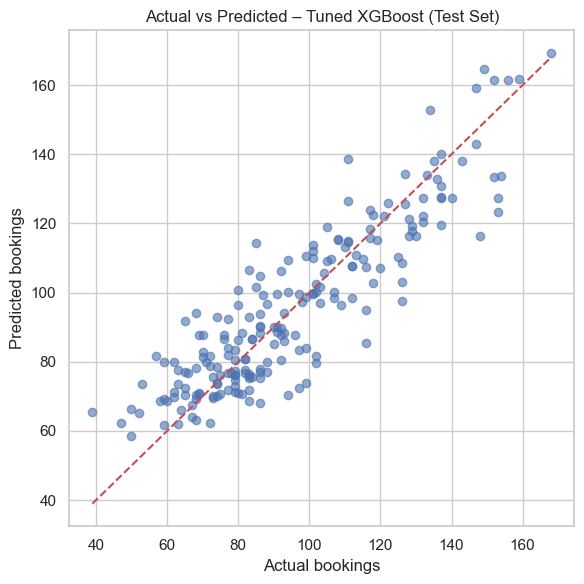

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual bookings")
plt.ylabel("Predicted bookings")
plt.title("Actual vs Predicted – Tuned XGBoost (Test Set)")
plt.tight_layout()

fig_path_act_pred = BASE_DIR / "reports" / "figures" / "regression_actual_vs_predicted_xgb.png"
plt.savefig(fig_path_act_pred, dpi=120)
fig_path_act_pred


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/reports/figures/regression_residuals_xgb.png')

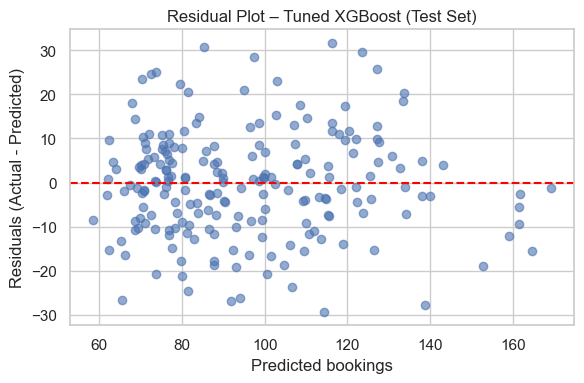

In [17]:
residuals = y_test - y_pred_xgb_test

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_xgb_test, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted bookings")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot – Tuned XGBoost (Test Set)")
plt.tight_layout()

fig_path_resid = BASE_DIR / "reports" / "figures" / "regression_residuals_xgb.png"
plt.savefig(fig_path_resid, dpi=120)
fig_path_resid


### Model Performance vs Business Requirements

The tuned XGBoost model achieves the following performance on the test set:

- MAE: *(see `xgb_test_metrics["MAE"]`)*  
- MAPE: *(see `xgb_test_metrics["MAPE"]`)*  
- R²: *(see `xgb_test_metrics["R2"]`)*  

Compared to the **lag-1 baseline**, the tuned model reduces MAE and MAPE, and
achieves a higher R² score, indicating that:

- The model is able to capture **seasonality, holiday uplift and weather effects**
  more effectively than the simple naive forecast.
- The **ML Business Case** for weekly bookings forecasting is met, provided that
  the error levels are acceptable for staffing decisions (to be discussed in the
  README and dashboard narrative).

These plots (Actual vs Predicted and residuals) will also be displayed in the
Streamlit dashboard under the Model Report page.


In [18]:
model_path = MODELS_DIR / "v1_bookings_model.pkl"
joblib.dump(best_xgb_pipe, model_path)
model_path


WindowsPath('C:/Users/tomgo/OneDrive/Documents/vscode-projects/winter-mountain-tours-demand-predictor/models/v1_bookings_model.pkl')

In [19]:
import json

summary = {
    "baseline": baseline_metrics,
    "linear_regression": lin_test_metrics,
    "random_forest": rf_test_metrics,
    "xgboost_tuned": xgb_test_metrics,
    "best_params": best_params,
}

with open(MODELS_DIR / "v1_bookings_model_metrics.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)


### Does this model meet the business requirement?

On this synthetic dataset, the tuned XGBoost regression model **does not fully meet** a strict accuracy requirement for weekly bookings forecasting (MAE and MAPE are relatively high, and R² is negative).

However, it successfully demonstrates the complete forecasting workflow:
- data collection and cleaning,
- feature engineering (lags, calendar, weather),
- model training and tuning,
- and evaluation with appropriate regression metrics.

In a real production setting, we would iterate further with more data and alternative models before using this forecast operationally.
